1. Разделить на треин и тест
2. Стандартизировать данные
3. Заполнить пропуски
4. Обработать выбросы
5. Сгенерировать новые фичи

6. Обучить модель
7. Подобрать гиперпараметры для модели
8. Кросс валидация
9. Проследить за переобучением
10. Посчитать метрики

11. Зафиксировать результаты эксперимента
12. Сохранить модели
13. Сохранить версии библиотек

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [74]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

TRAIN_PREP_DATASET_PATH = 'course_project_train_prep.csv'
TEST_PREP_DATASET_PATH = 'course_project_test_prep.csv'

TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

SCALER_FILE_PATH = 'models/scaler.pkl'
MODEL_FILE_PATH = 'models/model.pkl'

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    #Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [11]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


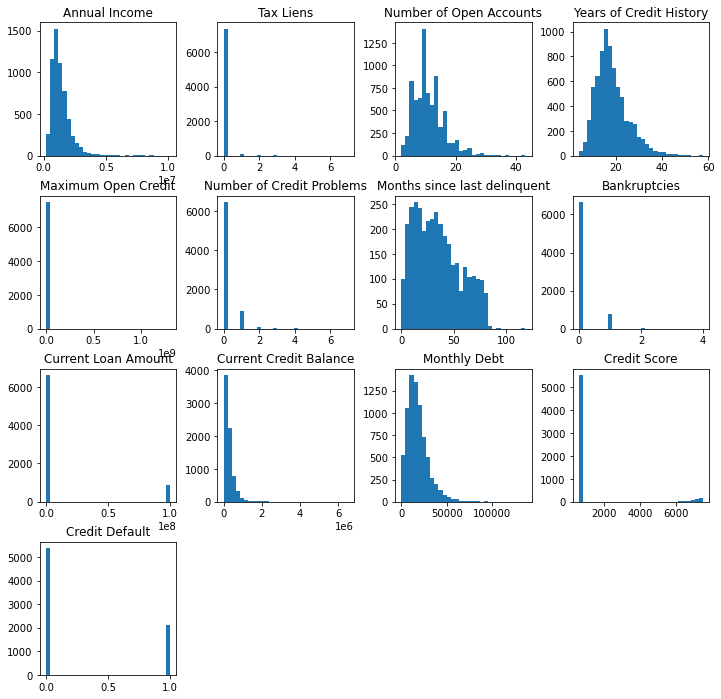

In [12]:
train_df.hist(figsize=(12, 12), bins=30, grid=False);

#### gaps

In [13]:
# filling with mean values
train_df['Annual Income'].loc[train_df['Annual Income'].isna()] = train_df['Annual Income'].mean()
train_df['Months since last delinquent'].loc[train_df['Months since last delinquent'].isna()] = train_df['Months since last delinquent'].mean()
train_df['Credit Score'].loc[train_df['Credit Score'].isna()] = train_df['Credit Score'].mean()

In [14]:
# filling with mode values
train_df['Years in current job'].loc[train_df['Years in current job'].isna()] = "10+ years"

In [15]:
# filling with zeroes
train_df['Bankruptcies'].loc[train_df['Bankruptcies'].isna()] = 0

In [16]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [17]:
# filling with mean values
test_df['Annual Income'].loc[test_df['Annual Income'].isna()] = test_df['Annual Income'].mean()
test_df['Months since last delinquent'].loc[test_df['Months since last delinquent'].isna()] = test_df['Months since last delinquent'].mean()
test_df['Credit Score'].loc[test_df['Credit Score'].isna()] = test_df['Credit Score'].mean()

In [18]:
# filling with mode values
test_df['Years in current job'].loc[test_df['Years in current job'].isna()] = "10+ years"

In [19]:
# filling with zeroes
test_df['Bankruptcies'].loc[test_df['Bankruptcies'].isna()] = 0

#### outliers

#### new features

In [20]:
train_df['Years in current job'] = train_df['Years in current job'].replace(
    {"< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4, "5 years": 5,
     "6 years": 6, "7 years": 7, "8 years": 8, "9 years": 9, "10+ years": 10})

In [21]:
train_df['Purpose'] = train_df['Purpose'].replace(
    {"debt consolidation ": 0, "other": 1, "home improvements": 2, "business loan": 3, "buy a car": 4, "medical bills": 5,
     "major purchase": 6, "take a trip": 7, "buy house": 8, "small business": 9, "wedding": 10,
     "moving": 11, "educational expenses": 12, "vacation": 13, "renewable energy": 14})

In [22]:
train_df["For Long Term"] = pd.get_dummies(train_df["Term"])["Long Term"]

In [23]:
train_df = pd.concat([train_df, pd.get_dummies(train_df["Home Ownership"])], axis=1)

In [24]:
# train_df.drop(["Home Ownership", "Term"], axis=1, inplace=True)

In [25]:
test_df['Years in current job'] = test_df['Years in current job'].replace(
    {"< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4, "5 years": 5,
     "6 years": 6, "7 years": 7, "8 years": 8, "9 years": 9, "10+ years": 10})

In [26]:
test_df['Purpose'] = test_df['Purpose'].replace(
    {"debt consolidation ": 0, "other": 1, "home improvements": 2, "business loan": 3, "buy a car": 4, "medical bills": 5,
     "major purchase": 6, "take a trip": 7, "buy house": 8, "small business": 9, "wedding": 10,
     "moving": 11, "educational expenses": 12, "vacation": 13, "renewable energy": 14})

In [27]:
test_df["For Long Term"] = pd.get_dummies(test_df["Term"])["Long Term"]

In [28]:
test_df = pd.concat([test_df, pd.get_dummies(test_df["Home Ownership"])], axis=1)

In [29]:
test_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,For Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.00,2500.00000,2500.000000
mean,1.366922e+06,6.089200,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106800,1.215572e+07,2.963966e+05,18271.340000,1234.516860,0.255600,0.002800,0.49,0.09920,0.408000
std,8.175891e+05,3.648913,0.386291,4.852774,7.254659,1.511983e+06,0.559894,14.882002,0.356994,3.226097e+07,3.783020e+05,11543.881469,1551.352573,0.436285,0.052851,0.50,0.29899,0.491561
min,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.000000,0.000000,0.00,0.00000,0.000000
25%,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,33.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.000000,0.000000,0.000000,0.00,0.00000,0.000000
50%,1.366922e+06,6.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,34.181261,0.000000,3.223660e+05,2.073850e+05,16642.500000,738.000000,0.000000,0.000000,0.00,0.00000,0.000000
75%,1.488726e+06,10.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,34.181261,0.000000,5.225825e+05,3.663485e+05,24146.000000,1234.516860,1.000000,0.000000,1.00,0.00000,1.000000
max,1.497561e+07,10.000000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,1.000000,1.000000,1.00,1.00000,1.000000


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### saving of prep datasets

In [31]:
train_df.to_csv(TRAIN_PREP_DATASET_PATH, index=False, encoding='utf-8')

### part 2

In [32]:
base_df = pd.read_csv(TRAIN_DATASET_PATH)
df = pd.read_csv(TRAIN_PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,For Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,...,99999999.0,47386.0,7914.0,749.0,0,0,0,0,1,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,...,264968.0,394972.0,18373.0,737.0,1,1,0,0,1,0
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,...,99999999.0,308389.0,13651.0,742.0,0,0,0,1,0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,...,121396.0,95855.0,11338.0,694.0,0,0,0,0,1,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,...,125840.0,93309.0,7180.0,719.0,0,0,0,0,0,1


#### target variable and criteria

In [33]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = ['Home Ownership','Annual Income','Years in current job','Tax Liens',
                      'Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                      'Number of Credit Problems','Months since last delinquent','Bankruptcies',
                      'Purpose','Term','Current Loan Amount','Current Credit Balance',
                      'Monthly Debt','Credit Score']

NEW_FEATURE_NAMES = ['For Long Term', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']

In [34]:
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History','Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent','Bankruptcies', 'Current Loan Amount',
                     'Current Credit Balance','Monthly Debt','Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

#### train/test split + scaling

In [35]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.225,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718341
1    0.281659
Name: Credit Default, dtype: float64

0    0.718009
1    0.281991
Name: Credit Default, dtype: float64

In [36]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_train_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])

X_train = X_train_norm.copy()

X_test_norm = X_test.copy()
X_test_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(X_test_norm[NUM_FEATURE_NAMES])

X_test = X_test_norm.copy()

In [37]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [38]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### part 3

In [39]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

In [40]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_test = df_test[TARGET_NAME]

In [41]:
test_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,For Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.00,2500.00000,2500.000000
mean,1.366922e+06,6.089200,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106800,1.215572e+07,2.963966e+05,18271.340000,1234.516860,0.255600,0.002800,0.49,0.09920,0.408000
std,8.175891e+05,3.648913,0.386291,4.852774,7.254659,1.511983e+06,0.559894,14.882002,0.356994,3.226097e+07,3.783020e+05,11543.881469,1551.352573,0.436285,0.052851,0.50,0.29899,0.491561
min,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.000000,0.000000,0.00,0.00000,0.000000
25%,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,33.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.000000,0.000000,0.000000,0.00,0.00000,0.000000
50%,1.366922e+06,6.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,34.181261,0.000000,3.223660e+05,2.073850e+05,16642.500000,738.000000,0.000000,0.000000,0.00,0.00000,0.000000
75%,1.488726e+06,10.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,34.181261,0.000000,5.225825e+05,3.663485e+05,24146.000000,1234.516860,1.000000,0.000000,1.00,0.00000,1.000000
max,1.497561e+07,10.000000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,1.000000,1.000000,1.00,1.00000,1.000000


In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [43]:
test_df = test_df.drop(columns=CAT_FEATURE_NAMES)

In [44]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,For Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.00,2500.00000,2500.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106800,1.215572e+07,2.963966e+05,18271.340000,1234.516860,0.255600,0.002800,0.49,0.09920,0.408000
std,8.175891e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,14.882002,0.356994,3.226097e+07,3.783020e+05,11543.881469,1551.352573,0.436285,0.052851,0.50,0.29899,0.491561
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.000000,0.000000,0.00,0.00000,0.000000
25%,9.365622e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,33.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.000000,0.000000,0.000000,0.00,0.00000,0.000000
50%,1.366922e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,34.181261,0.000000,3.223660e+05,2.073850e+05,16642.500000,738.000000,0.000000,0.000000,0.00,0.00000,0.000000
75%,1.488726e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,34.181261,0.000000,5.225825e+05,3.663485e+05,24146.000000,1234.516860,1.000000,0.000000,1.00,0.00000,1.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,1.000000,1.000000,1.00,1.00000,1.000000


In [45]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
 12  For Long Term                 2500 non-null   uint8  
 13  Hav

In [46]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    4175
0    4175
Name: Credit Default, dtype: int64

In [47]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


#Коэффициент детерминации (R^2 — R-квадрат) 
#— это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости,
#то есть объясняющими переменными. 

def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()] # we have there some values
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")
    

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [49]:
# df_copy = df[NUM_FEATURE_NAMES + NEW_FEATURE_NAMES].copy()
# df_test_copy = df_test[NUM_FEATURE_NAMES + NEW_FEATURE_NAMES].copy()

df_copy = X.copy()
df_test_copy = X_test.copy()

In [50]:
df_copy.isna().sum().sum()

0

### Annual income

In [51]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Annual Income'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5000000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5000000)

df_copy[feature_name].isna().sum()

44

In [52]:
%%time
annual_income_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7360280082777407
r2 на test: 0.4540888674544701
Wall time: 2.08 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Current Loan Amount

In [146]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Current Loan Amount'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5000000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5000000)

df_copy[feature_name].isna().sum()

870

In [147]:
%%time
current_loan_amount_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7275062069744198
r2 на test: 0.4163339124057286
Wall time: 1.88 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Credit Score

In [51]:
df_copy["Credit Score"].describe()

count    7500.000000
mean     1151.087498
std      1428.207201
min       585.000000
25%       718.000000
50%       738.000000
75%      1151.087498
max      7510.000000
Name: Credit Score, dtype: float64

In [90]:
# def preprocess_outlier(df, col, threshold):
#     # можно по threshold отсекать, а можно и по квантилям
#     df.loc[df[col] > threshold, col] = np.nan
#     return df

# feature_name = 'Credit Score'
# df_copy = preprocess_outlier(df_copy, feature_name, threshold=3000)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3000)

# df_copy[feature_name].isna().sum()

400

In [91]:
# %%time
# credit_score_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9930641479524142
r2 на test: 0.9873265124066222
Wall time: 1.88 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Current Credit Balance

In [52]:
df_copy["Current Credit Balance"].loc[df_copy["Current Credit Balance"] > 1000000].count()

188

In [150]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Current Credit Balance'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=1000000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

188

In [151]:
%%time

current_credit_balance_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8501171834515098
r2 на test: 0.7101230687792228
Wall time: 2.09 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [85]:
df_copy.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,For Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.341595e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.116933,308015.778793,265671.880052,18314.454133,1151.087498,0.259200,0.001600,0.484933,0.086267,0.427200
std,6.313500e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.642661,0.346904,176368.464496,205531.509571,11926.764673,1428.207201,0.438225,0.039971,0.499806,0.280776,0.494705
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.309572e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,34.692600,0.000000,175670.000000,114213.750000,10067.500000,718.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.366392e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,34.692600,0.000000,267015.659633,209304.000000,16076.500000,738.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.498492e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,34.692600,0.000000,419552.082068,359513.250000,23818.000000,1151.087498,1.000000,0.000000,1.000000,0.000000,1.000000
max,4.906028e+06,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,789030.000000,997899.000000,136679.000000,7510.000000,1.000000,1.000000,1.000000,1.000000,1.000000


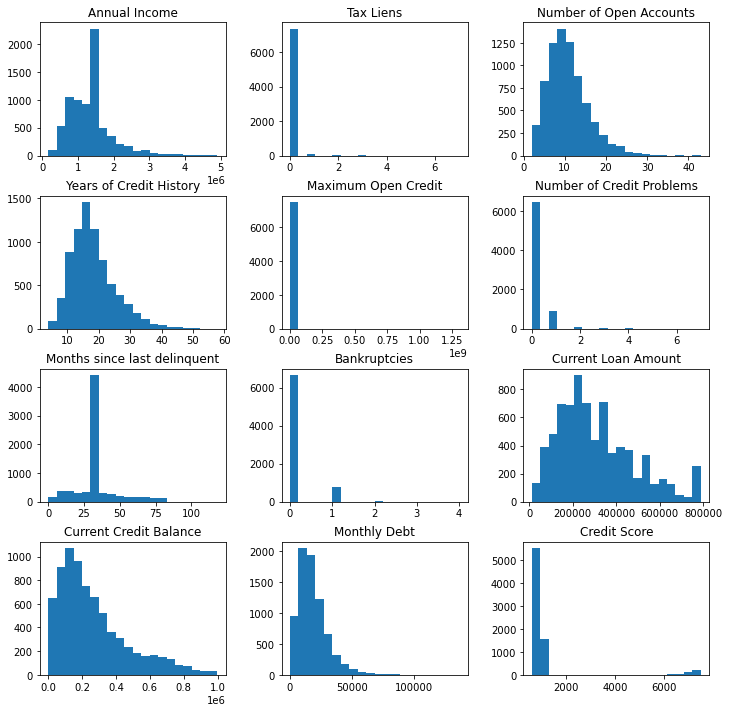

In [153]:
df_copy[NUM_FEATURE_NAMES].hist(figsize=(12, 12), bins=20, grid=False);

In [ ]:
test_df['Annual Income'].loc[test_df['Annual Income'] > 5000000] = test_df['Annual Income'].median()
test_df['Current Loan Amount'].loc[test_df['Current Loan Amount'] > 5000000] = test_df['Current Loan Amount'].median()
test_df['Current Credit Balance'].loc[test_df['Current Credit Balance'] > 1000000] = test_df['Current Credit Balance'].median()

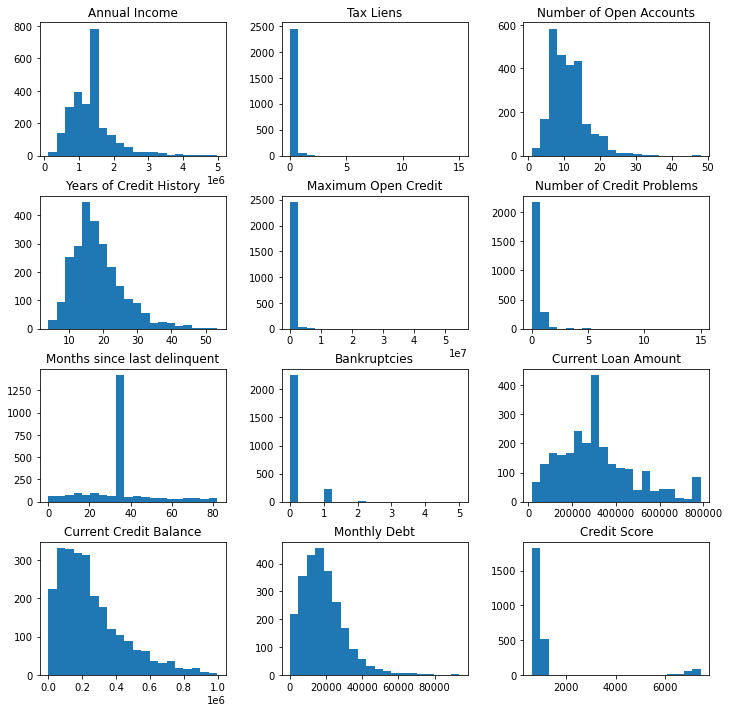

In [55]:
test_df[NUM_FEATURE_NAMES].hist(figsize=(12, 12), bins=20, grid=False);

In [56]:
X = df_copy
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

0    0.718667
1    0.281333
Name: Credit Default, dtype: float64

In [57]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    4848
0    4848
Name: Credit Default, dtype: int64

In [58]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

## XGBoost

In [59]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[21:03:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      4848
           1       0.88      0.66      0.76      4848

    accuracy                           0.79      9696
   macro avg       0.81      0.79      0.78      9696
weighted avg       0.81      0.79      0.78      9696

TEST

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       539
           1       0.57      0.39      0.46       211

    accuracy                           0.75       750
   macro avg       0.68      0.64      0.65       750
weighted avg       0.73      0.75      0.73       750

CONFUSION MATRIX

col_0

In [60]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [61]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [62]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

[21:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'reg_lambda': 1.3}

0.7469206894629546

Wall time: 2.15 s


In [63]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

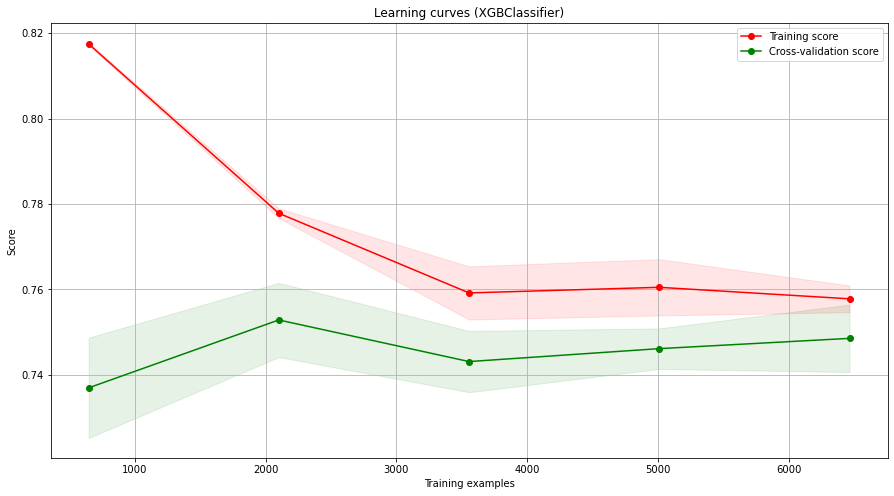

In [64]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

In [65]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.5740576 , 0.42594242],
       [0.6095045 , 0.39049548],
       [0.58827126, 0.41172877],
       ...,
       [0.54341507, 0.4565849 ],
       [0.7060091 , 0.2939909 ],
       [0.6126067 , 0.3873933 ]], dtype=float32)

In [66]:
threshold =0.45
# y_test_pred_probs[:, 1], y_test
precision_score(y_test, list(map(int, y_test_pred_probs[:, 1] > threshold)))


0.509009009009009

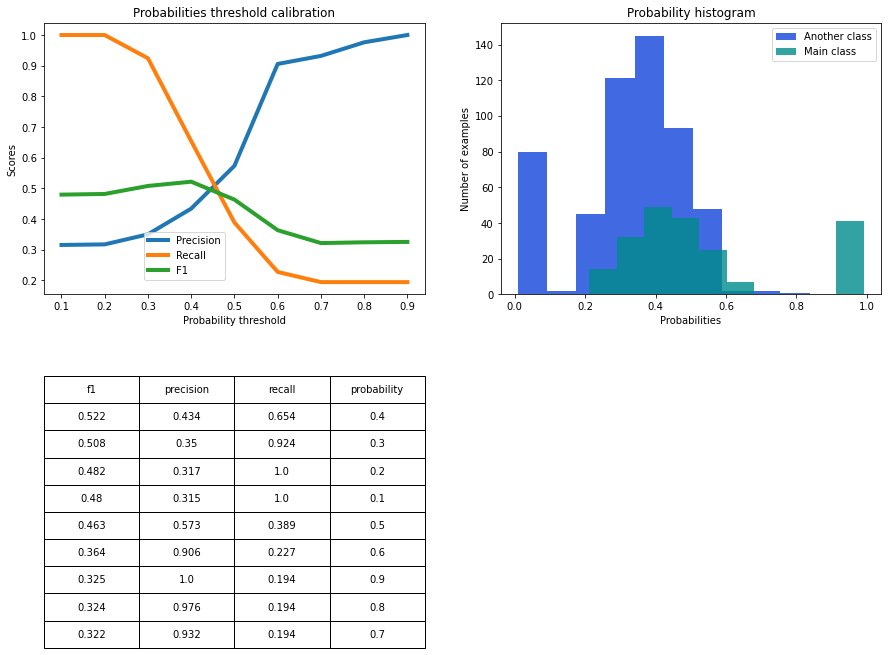

In [67]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

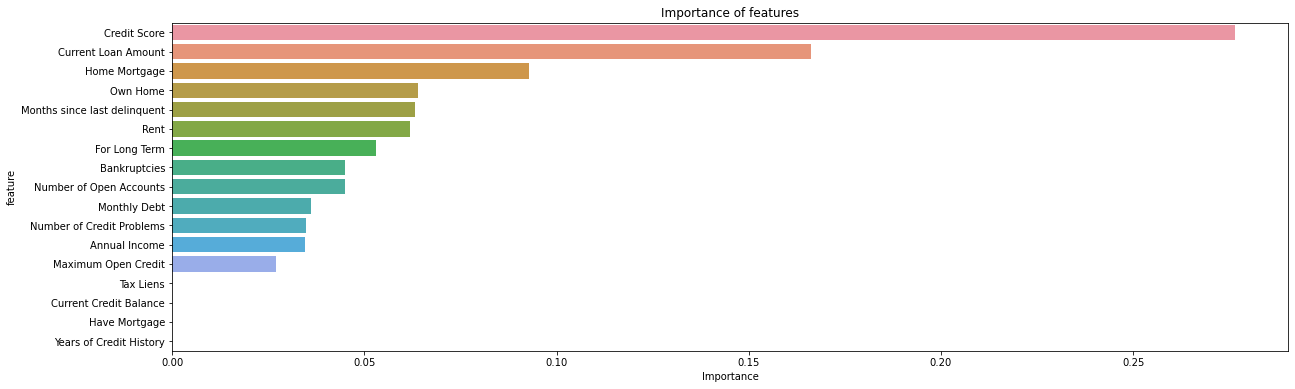

In [68]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=19)

In [69]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Home Mortgage',
 'Own Home',
 'Months since last delinquent',
 'Rent',
 'For Long Term',
 'Bankruptcies',
 'Number of Open Accounts',
 'Monthly Debt',
 'Number of Credit Problems',
 'Annual Income',
 'Maximum Open Credit',
 'Tax Liens',
 'Current Credit Balance',
 'Have Mortgage',
 'Years of Credit History']

In [70]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=1.5
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[21:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      4848
           1       0.88      0.67      0.76      4848

    accuracy                           0.79      9696
   macro avg       0.80      0.79      0.78      9696
weighted avg       0.80      0.79      0.78      9696

TEST

              precision    recall  f1-score   support

           0       0.79      0.89      0.83       539
           1       0.58      0.39      0.47       211

    accuracy                           0.75       750
   macro avg       0.68      0.64      0.65       750
weighted avg       0.73      0.75      0.73       750

CONFUSION MATRIX

col_0

In [75]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_xgb, file)

In [95]:
test_df = test_df[important_features_top]
predictions = final_xgb.predict(test_df)
submit = pd.DataFrame(predictions)

submit.rename(columns={0: 'Credit Default'}, inplace=True)
submit.value_counts()

Credit Default
0                 1703
1                  797
dtype: int64

In [100]:
submit['Id'] = range(0, len(submit))
cols = submit.columns.tolist()
cols = cols[-1:] + cols[:-1]
submit = submit[cols]
submit

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,0
2498,2498,0


In [103]:
submit.to_csv('maksymchuk_predictions.csv', index=False, encoding='utf-8')